In [ ]:
import os
import io

import ee
import geemap.core as geemap

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib

from urllib.request import urlopen, Request
from PIL import Image

import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from skimage.transform import resize
from skimage.io import imread
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

### Classifying imagery with Google Earth Engine
Use Google Earth Engine datasets and provided library for classification: https://developers.google.com/earth-engine/guides/machine-learning

In [2]:
ee.Authenticate()
ee.Initialize(project = 'ee-nikolaydragomirovzhechev')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


Supervised Classification 

In [3]:
# Define a function that scales and masks Landsat 8 surface reflectance images.
def prep_l8_imgs(image):
    """
        Scales and masks Landsat 8 surface reflectance images.
        Args:
            image: the image to be processed.
    """
    
    # Develop masks for unwanted pixels (fill, cloud, cloud shadow).
    qa_mask = image.select('QA_PIXEL').bitwiseAnd(0b11111).eq(0)
    saturation_mask = image.select('QA_RADSAT').eq(0)

    # Apply the scaling factors to the appropriate bands.
    def _get_factor_img(factor_names):
      factor_list = image.toDictionary().select(factor_names).values()
      return ee.Image.constant(factor_list)

    scale_img = _get_factor_img([
        'REFLECTANCE_MULT_BAND_.|TEMPERATURE_MULT_BAND_ST_B10'])
    offset_img = _get_factor_img([
        'REFLECTANCE_ADD_BAND_.|TEMPERATURE_ADD_BAND_ST_B10'])
    scaled = image.select('SR_B.|ST_B10').multiply(scale_img).add(offset_img)

    # Replace original bands with scaled bands and apply masks.
    return image.addBands(scaled, None, True).updateMask(qa_mask).updateMask(saturation_mask)

Dataset:  
https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2

In [4]:
# Make a cloud-free Landsat 8 surface reflectance composite.
l8_image = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterDate('2021-03-01', '2021-07-01')
    .map(prep_l8_imgs)
    .median())

In [5]:
l8_image

In [6]:
# Use these bands for prediction.
bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10']

# Load training points. The numeric property 'class' stores known labels.
points = ee.FeatureCollection('GOOGLE/EE/DEMOS/demo_landcover_labels')

# This property stores the land cover labels as consecutive
# integers starting from zero.
label = 'landcover'

# Overlay the points on the imagery to get training.
training = l8_image.select(bands).sampleRegions(
    collection=points, properties=[label], scale=30
)

Classification and Regression Trees (CART) is a decision tree algorithm that is used for both classification and regression tasks. It is a supervised learning algorithm that learns from labelled data to predict unseen data.

In [7]:
# Train a CART classifier with default parameters.
trained = ee.Classifier.smileCart().train(training, label, bands)

In [8]:
# Classify the image with the same bands used for training.
classified = l8_image.select(bands).classify(trained)
classified

In [9]:
# Display the inputs and the results.
m = geemap.Map()
m.set_center(-122.0877, 37.7880, 11)
m.add_layer(
    l8_image,
    {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.25},
    'image',
)
m.add_layer(
    classified,
    {'min': 0, 'max': 2, 'palette': ['orange', 'green', 'blue']},
    'classification',
)
m

Map(center=[37.788, -122.0877], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [10]:
# Define a function that scales and masks Landsat 8 surface reflectance images.
def prep_sr_l8(image):
  # Develop masks for unwanted pixels (fill, cloud, cloud shadow).
  qa_mask = image.select('QA_PIXEL').bitwiseAnd(0b11111).eq(0)
  saturation_mask = image.select('QA_RADSAT').eq(0)

  # Apply the scaling factors to the appropriate bands.
  def _get_factor_img(factor_names):
    factor_list = image.toDictionary().select(factor_names).values()
    return ee.Image.constant(factor_list)
  scale_img = _get_factor_img([
      'REFLECTANCE_MULT_BAND_.|TEMPERATURE_MULT_BAND_ST_B10'])
  offset_img = _get_factor_img([
      'REFLECTANCE_ADD_BAND_.|TEMPERATURE_ADD_BAND_ST_B10'])
  scaled = image.select('SR_B.|ST_B10').multiply(scale_img).add(offset_img)

  # Replace original bands with scaled bands and apply masks.
  return image.addBands(scaled, None, True).updateMask(
      qa_mask).updateMask(saturation_mask)


# Make a cloud-free Landsat 8 surface reflectance composite.
l8_image = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterDate('2018-01-01', '2019-01-01')
    .map(prep_sr_l8)
    .median())

# Use these bands for prediction.
bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']

# Manually created polygons.
forest1 = ee.Geometry.Rectangle(-63.0187, -9.3958, -62.9793, -9.3443)
forest2 = ee.Geometry.Rectangle(-62.8145, -9.206, -62.7688, -9.1735)
non_forest1 = ee.Geometry.Rectangle(-62.8161, -9.5001, -62.7921, -9.4486)
non_forest2 = ee.Geometry.Rectangle(-62.6788, -9.044, -62.6459, -8.9986)

# Make a FeatureCollection from the hand-made geometries.
polygons = ee.FeatureCollection([
    ee.Feature(non_forest1, {'class': 0}),
    ee.Feature(non_forest1, {'class': 0}),
    ee.Feature(forest1, {'class': 1}),
    ee.Feature(forest2, {'class': 1}),
])

# Get the values for all pixels in each polygon in the training.
training = l8_image.sampleRegions(
    # Get the sample from the polygons FeatureCollection.
    collection=polygons,
    # Keep this list of properties from the polygons.
    properties=['class'],
    # Set the scale to get Landsat pixels in the polygons.
    scale=30,
)

# Create an SVM classifier with custom parameters.
classifier = ee.Classifier.libsvm(kernelType='RBF', gamma=0.5, cost=10)

# Train the classifier.
trained = classifier.train(training, 'class', bands)

# Classify the image.
classified = l8_image.classify(trained)

# Display the classification result and the input image.
m = geemap.Map()
m.set_center(-62.836, -9.2399, 9)
m.add_layer(
    l8_image,
    {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.25},
    'image',
)
m.add_layer(polygons, {'color': 'yellow'}, 'training polygons')
m.add_layer(
    classified,
    {'min': 0, 'max': 1, 'palette': ['orange', 'green']},
    'deforestation',
)
m

Map(center=[-9.2399, -62.836], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [11]:
# Define a region of interest.
roi = ee.Geometry.BBox(-122.93, 36.99, -121.20, 38.16)

# Define a function that scales and masks Landsat 8 surface reflectance images.
def prep_sr_l8(image):
  """Scales and masks Landsat 8 surface reflectance images."""
  # Develop masks for unwanted pixels (fill, cloud, cloud shadow).
  qa_mask = image.select('QA_PIXEL').bitwiseAnd(0b1111).eq(0)
  saturation_mask = image.select('QA_RADSAT').eq(0)

  # Apply the scaling factors to the appropriate bands.
  def _get_factor_img(factor_names):
    factor_list = image.toDictionary().select(factor_names).values()
    return ee.Image.constant(factor_list)

  scale_img = _get_factor_img([
      'REFLECTANCE_MULT_BAND_.|TEMPERATURE_MULT_BAND_ST_B10'])
  offset_img = _get_factor_img([
      'REFLECTANCE_ADD_BAND_.|TEMPERATURE_ADD_BAND_ST_B10'])
  scaled = image.select('SR_B.|ST_B10').multiply(scale_img).add(offset_img)

  # Replace original bands with scaled bands and apply masks.
  return image.addBands(scaled, None, True).updateMask(
      qa_mask).updateMask(saturation_mask)


# Make a cloud-free Landsat 8 surface reflectance composite.
input_image = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(roi)
    .filterDate('2020-03-01', '2020-07-01')
    .map(prep_sr_l8)
    .median()
    .setDefaultProjection('EPSG:4326', None, 30)
    .select(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'])
)

# Use MODIS land cover, IGBP classification, for training.
modis = ee.Image('MODIS/006/MCD12Q1/2020_01_01').select('LC_Type1')

# Sample the input imagery to get a FeatureCollection of training data.
sample = input_image.addBands(modis).sample(
    region=roi, numPixels=5000, seed=0, geometries=True, tileScale=16
)

# The randomColumn() method will add a column of uniform random
# numbers in a column named 'random' by default.
sample = sample.randomColumn()

# # Sample the input imagery to get a FeatureCollection of training data.
# training = input_image.addBands(modis).sample(
#     region=roi, numPixels=5000, seed=0
# )

split = 0.7  # Roughly 70% training, 30% testing.
training = sample.filter(ee.Filter.lt('random', split))
display('Training size:', training.size())
validation = sample.filter(ee.Filter.gte('random', split))

# Spatial join.
dist_filter = ee.Filter.withinDistance(
    distance=1000, leftField='.geo', rightField='.geo', maxError=10
)

join = ee.Join.inverted()

# Apply the join.
training = join.apply(training, validation, dist_filter)
display('Training size after spatial filtering:', training.size())

# Make a Random Forest classifier and train it.
classifier = ee.Classifier.smileRandomForest(10).train(
    features=training,
    classProperty='LC_Type1',
    inputProperties=['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'],
)

# Classify the input imagery.
classified = input_image.classify(classifier)

# Get a confusion matrix representing resubstitution accuracy.
train_accuracy = classifier.confusionMatrix()
display('Resubstitution error matrix:', train_accuracy)
display('Training overall accuracy:', train_accuracy.accuracy())

# Sample the input with a different random seed to get validation data.
validation = (
    input_image.addBands(modis)
    .sample(
        region=roi,
        numPixels=5000,
        seed=1,
        # Filter the result to get rid of any null pixels.
    )
    .filter(ee.Filter.notNull(input_image.bandNames()))
)

# Classify the validation data.
validated = validation.classify(classifier)

# Get a confusion matrix representing expected accuracy.
test_accuracy = validated.errorMatrix('LC_Type1', 'classification')
display('Validation error matrix:', test_accuracy)
display('Validation overall accuracy:', test_accuracy.accuracy())

# Define a palette for the IGBP classification.
igbp_palette = [
    'aec3d4',  # water
    '152106', '225129', '369b47', '30eb5b', '387242',  # forest
    '6a2325', 'c3aa69', 'b76031', 'd9903d', '91af40',  # shrub, grass
    '111149',  # wetlands
    'cdb33b',  # croplands
    'cc0013',  # urban
    '33280d',  # crop mosaic
    'd7cdcc',  # snow and ice
    'f7e084',  # barren
    '6f6f6f'   # tundra
]

# Display the input and the classification with geemap in a notebook.
m = geemap.Map()
m.center_object(roi, 10)
m.add_layer(
    input_image.clip(roi),
    {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.25},
    'landsat',
)
m.add_layer(
    classified.clip(roi),
    {'palette': igbp_palette, 'min': 0, 'max': 17},
    'classification',
)
m

'Training size:'

'Training size after spatial filtering:'

'Resubstitution error matrix:'

'Training overall accuracy:'

'Validation error matrix:'

'Validation overall accuracy:'

Map(center=[37.57451999977034, -122.06500000000011], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Using classifier smileGradientTreeBoost:  
    Training overall accuracy: 0.9108      Validation overall accuracy: 0.6517303460692139


Import classfier to EE project and reuse.

Unsupervised Classification (clustering)

In [12]:
# Define a region in which to generate a segmented map.
region = ee.Geometry.Rectangle(29.7, 30, 32.5, 31.7)

# Load a Landsat composite for input.
input = (
    ee.ImageCollection('LANDSAT/COMPOSITES/C02/T1_L2_32DAY')
    .filterDate('2001-05', '2001-06')
    .first()
    .clip(region)
)

# Display the sample region.
m = geemap.Map()
m.set_center(31.5, 31.0, 8)
m.add_layer(ee.Image().paint(region, 0, 2), {}, 'region')

# Make the training dataset.
training = input.sample(region=region, scale=30, numPixels=5000)

# Instantiate the clusterer and train it.
clusterer = ee.Clusterer.wekaKMeans(15).train(training)

# Cluster the input using the trained clusterer.
result = input.cluster(clusterer)

# Display the clusters with random colors.
m.add_layer(result.randomVisualizer(), {}, 'clusters')
m

Map(center=[31.0, 31.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

Overall Accuracy for both training and validation sets.  
Confusion Matrices for both training and validation, to show class-specific accuracy.

In [13]:
# Accuracy values from Earth Engine and convert to variables.
train_accuracy_value = train_accuracy.accuracy().getInfo()
test_accuracy_value = test_accuracy.accuracy().getInfo()

In [14]:
# Confusion matrix arrays from Earth Engine.
train_conf_matrix = train_accuracy.getInfo()
test_conf_matrix = test_accuracy.getInfo()

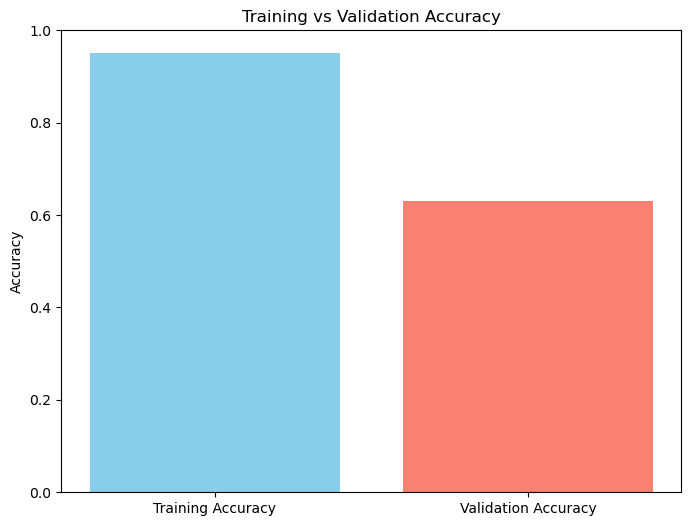

In [15]:
# Plot training and validation accuracy.
accuracies = [train_accuracy_value, test_accuracy_value]
labels = ['Training Accuracy', 'Validation Accuracy']

plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.show()

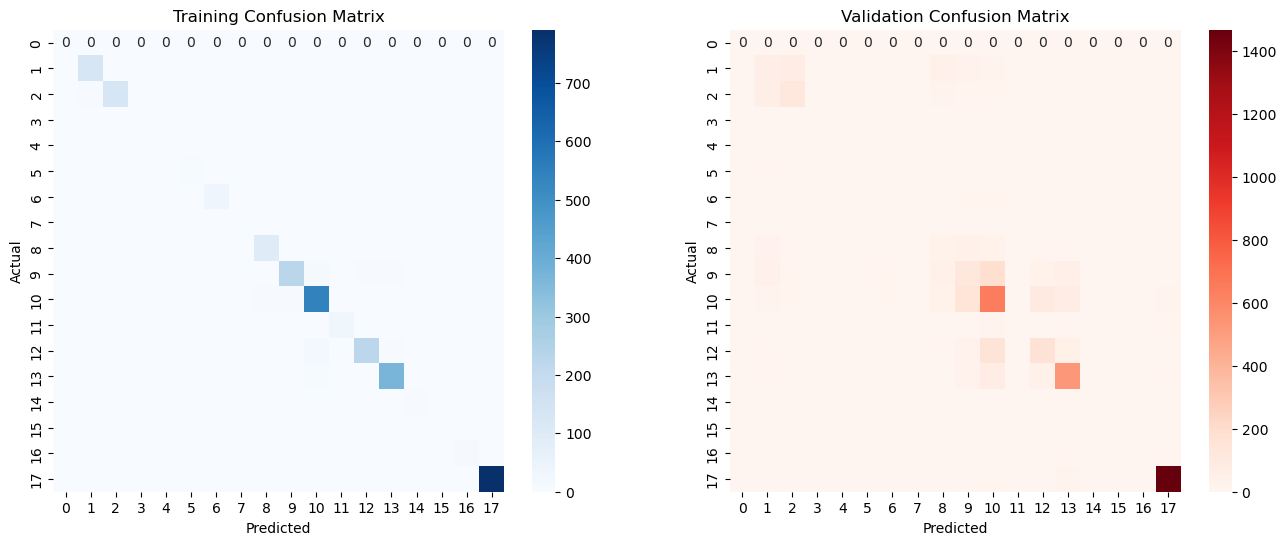

In [16]:
class_labels = [str(i) for i in range(len(train_conf_matrix))]  # Modify as per class count

# Create DataFrames for both matrices.
train_conf_df = pd.DataFrame(train_conf_matrix, index=class_labels, columns=class_labels)
test_conf_df = pd.DataFrame(test_conf_matrix, index=class_labels, columns=class_labels)

# Plot the confusion matrices.
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(train_conf_df, annot=True, cmap='Blues', fmt='g', ax=axes[0])
axes[0].set_title('Training Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(test_conf_df, annot=True, cmap='Reds', fmt='g', ax=axes[1])
axes[1].set_title('Validation Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()

### Classifying imagery with TensorFlow
Use TensorFlow API: https://www.tensorflow.org/tutorials/images/classification  
Dataset from Kaggle: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification?resource=downloadlips/

sattelite_images/  
&nbsp;    clody/  
&nbsp;    desert/  
&nbsp;    green_area/  
&nbsp;    water/  

In [ ]:
dataset_path = pathlib.Path("Datasets/Classification_Tasks/data")

image_count = len(list(dataset_path.rglob('*.jpg')))
print(image_count)

In [ ]:
clody = list(dataset_path.glob('cloudy/*.jpg'))
PIL.Image.open(str(clody[0]))

In [ ]:
desert = list(dataset_path.glob('desert/*.jpg'))
PIL.Image.open(str(desert[0]))

In [ ]:
green_area = list(dataset_path.glob('green_area/*.jpg'))
PIL.Image.open(str(green_area[0]))

In [ ]:
water = list(dataset_path.glob('water/*.jpg'))
PIL.Image.open(str(water[0]))

Create a dataset  
80% of the images for training and 20% for validation

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Visualize the data

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

SVM example:

In [128]:
Categories = ['cloudy', 'desert', 'green_area', 'water']
flat_data_arr = [] #input array
target_arr = [] #output array
datadir = dataset_path

#path which contains all the categories of images
for i in Categories:
    
    print(f'loading... category : {i}')
    path = os.path.join(datadir, i)
    count = 0
    
    for img in os.listdir(path):
        if count >= 350:  # to limit number of images
            break
        
        img_array = imread(os.path.join(path,img))
        img_resized = resize(img_array,(150, 150 , 3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(i))

        count += 1
        
    print(f'loaded category:{i} successfully')
    
flat_data = np.array(flat_data_arr)
target = np.array(target_arr)
df = pd.DataFrame(flat_data) #dataframe
df['Target'] = target
x = df.iloc[:, :-1] #input data 
y = df.iloc[:, -1] #output data

loading... category : cloudy
loaded category:cloudy successfully
loading... category : desert
loaded category:desert successfully
loading... category : green_area
loaded category:green_area successfully
loading... category : water
loaded category:water successfully


In [129]:
param_grid = {'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc = svm.SVC(probability = True)
model = GridSearchCV(svc, param_grid)

In [130]:
model

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['rbf', 'poly']})

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 77, stratify = y)
print('Splitted Successfully.')

model.fit(x_train, y_train)
print('The Model is Trained Succesfully.')

Splitted Successfully.


In [ ]:
y_predict = model.predict(x_test)
print(f'Predicted Data is : {y_predict}')
print('Actual data is:')
print(y_test)
print(f'The model is { metrics.accuracy_score(y_predict, y_test) * 100 }% accurate.')

Saved results from initial run are:
Predicted Data is : [2 3 0 1 1 0 2 1 2 1 3 2 3 3 3 2 2 1 3 3 0 3 0 0 0 1 2 0 3 1 1 1 2 0 3 0 2
 3 0 1]  
Actual data is:  
120    2  
185    3  
37     0  
54     1  
84     1  
23     0  
139    2  
85     1  
116    2  
94     1  
189    3  
125    2  
179    3  
178    3  
182    3  
118    2  
123    2  
82     1  
161    3  
192    3  
20     0  
184    3  
32     0  
31     0  
48     0  
57     1  
104    2  
39     0  
160    3  
75     1  
68     1  
74     1  
127    2  
43     0  
142    2  
47     0  
136    2  
180    3  
24     0  
59     1  
Name: Target, dtype: int32  
The model is 97.5% accurate.

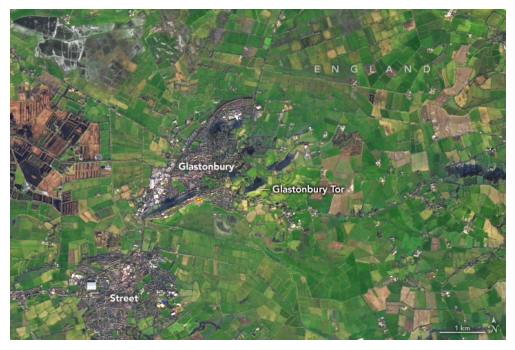

In [120]:
# Image examples
url_green = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/153000/153139/glastonbury_oli_20240119.jpg'
url_desert = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/153000/153475/lakealgeria_oli2_20240812.jpg'
url_cloudy = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/78000/78562/spacific_tmo_2012180.jpg'
url_water = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/145000/145610/capricorn_oli_2019244.jpg'

# Read and plot an image
req = Request(url_green, headers = {'User-Agent': 'Mozilla/5.0'})
img_data = urlopen(req).read()
img = Image.open(io.BytesIO(img_data))

plt.imshow(img)
plt.axis('off')
plt.show()

# Ensure the image is in RGB mode
img = img.convert('RGB')
# Resize the image to 150x150
img_resize = img.resize((150, 150))
# Convert the resized image to a NumPy array
img_array = np.array(img_resized)
# img_array = img_array / 255.0
l = [img_array.flatten()]

probability = model.predict_proba(l)

In [127]:
# Debugging: Print input shape and values
print("Input shape:", np.array(l).shape)
print("Flattened input sample:", l[0][:10])  # Print first 10 elements for inspection

Input shape: (1, 67500)
Flattened input sample: [0.00073818 0.00104261 0.00121492 0.00073818 0.00104422 0.00121041
 0.00073818 0.00103954 0.00122353 0.00073818]


In [121]:
probability

array([[0.93178517, 0.02294341, 0.02013128, 0.02514014]])

In [122]:
# Predict image
for ind, val in enumerate(Categories):
    print(f'{val} = { probability[0][ind] * 100 }%')
print('The predicted image is: '+Categories[model.predict(l)[0]])

cloudy = 93.17851746456452%
desert = 2.2943408679865085%
green_area = 2.0131277511508805%
water = 2.5140139162980955%
The predicted image is: cloudy
